In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats 
import numpy as np
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
%matplotlib inline

# Importation des données

In [62]:
df = pd.read_csv('data/data.csv')
df.head()

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


# Nettoyage de données

In [3]:
# On supprimes les colonnes inutiles
df.columns
del df['Unnamed: 0']
del df['index']
df.head()

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [4]:
# On regarde les données manquantes
print(df.isnull().sum())
#df.head()

date           91
cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo         106
embauche        0
dtype: int64


In [5]:
# On supprime les données manquantes pour les variables catégoriques ainsi que pour la date
df.dropna(subset = ['cheveux', 'sexe', 'diplome', 'specialite', 'dispo', 'date'], inplace=True)

# on remplace les données manquantes par la moyenne pour les variables quantitatives
df.fillna(df.mean(), inplace=True)

In [6]:
# Observons les données non catégoriques
df[['age', 'exp', 'salaire', 'note']].describe()

,age,exp,salaire,note
count,19408.000000,19408.000000,19408.000000,19408.000000
mean,34.987162,9.497204,34970.906337,75.184858
std,9.577133,3.005781,4988.966442,17.060947
min,-3.000000,-2.000000,14128.000000,8.680000
25%,29.000000,7.000000,31617.000000,63.820000
50%,35.000000,9.000000,34970.906337,75.184858
75%,41.000000,12.000000,38336.250000,86.572500
max,72.000000,23.000000,53977.000000,143.220000


In [7]:
# Les notes sont sur 100 donc on regarde les notes qui sont au dessus de 100
# Regardons également les âges <= 0 et trop bas
# Regardons également les d'années d'expérience négatives
# Regardons les personnes ayants un âge inférieur ou égal au nombre d'années d'expérience également

In [8]:
# On supprime les données qui me semblent aberrantes  
print(len(df[df['age']<=0]))
print(len(df[df['note']>100]))
print(len(df[df['exp']<0]))
print(len(df[df['age']<=df['exp']]))

df = df[(df['age']>0) & (df['note']<=100) & (df['exp']>=0) & (df['age']>df['exp'])]

df[['age', 'exp', 'salaire', 'note']].describe()

5
1424
2
127


,age,exp,salaire,note
count,17868.000000,17868.000000,17868.000000,17868.000000
mean,35.147635,9.480230,35301.385567,72.615651
std,9.363482,2.999916,4839.784533,14.862103
min,7.000000,0.000000,14128.000000,8.680000
25%,29.000000,7.000000,32039.000000,62.680000
50%,35.000000,9.000000,35243.500000,73.700000
75%,41.000000,11.000000,38561.250000,83.700000
max,72.000000,23.000000,53977.000000,100.000000


In [9]:
print(df[df['age']<=10])
# On peut supposer que ces données sont aberrantes car ces gens là ont moins de 10 ans et un nombre d'années
# d'expérience considérable par rapport à leur âge pour certains ainsi qu'un diplôme pour la plupart 
# nécessitant plusieurs années d'études afin de l'obtenir.
# Je décide donc de supprimer ces données du dataset

df = df[df['age']>10]
df[['age', 'exp', 'salaire', 'note']].describe()

             date  cheveux   age  exp  salaire sexe   diplome   specialite  \
164    2011-02-18     brun  10.0  9.0  38767.0    F    master  archeologie   
405    2013-05-01    blond  10.0  6.0  39318.0    M   licence       forage   
1080   2014-11-12  chatain   9.0  6.0  36375.0    F    master    detective   
4782   2011-03-27  chatain  10.0  9.0  34707.0    F  doctorat    detective   
4849   2011-01-20     brun   9.0  7.0  34444.0    F    master     geologie   
5496   2010-06-07  chatain  10.0  1.0  33495.0    F   licence     geologie   
8973   2014-09-30     brun   8.0  4.0  36759.0    F       bac     geologie   
10193  2013-08-02     brun  10.0  9.0  29404.0    F   licence     geologie   
15311  2011-04-14     brun  10.0  8.0  33489.0    F   licence     geologie   
15390  2014-09-21     brun   8.0  7.0  33866.0    F   licence     geologie   
15711  2013-01-08     brun   9.0  8.0  33851.0    M    master     geologie   
16476  2011-01-23  chatain  10.0  4.0  31749.0    F    master   

,age,exp,salaire,note
count,17848.000000,17848.000000,17848.000000,17848.000000
mean,35.176655,9.483514,35303.103895,72.606103
std,9.328436,2.999049,4841.031696,14.862451
min,11.000000,0.000000,14128.000000,8.680000
25%,29.000000,7.000000,32039.000000,62.670000
50%,35.000000,9.000000,35246.000000,73.690000
75%,41.000000,11.000000,38566.000000,83.680000
max,72.000000,23.000000,53977.000000,100.000000


# Partie I: Statistiques descriptives

## Décrire le jeu de données.

0    0.883853
1    0.116147
Name: embauche, dtype: float64


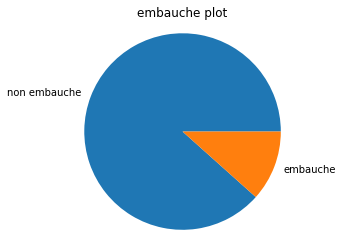

In [10]:
# Taille des clusters
len_clusters = df['embauche'].value_counts()
print(len_clusters/sum(len_clusters))

# Plot
plt.pie(len_clusters, labels=['non embauche', 'embauche'])
plt.axis('equal')
plt.title('embauche plot')
plt.show()

geologie       0.516865
forage         0.216887
detective      0.201871
archeologie    0.064377
Name: specialite, dtype: float64
blond      0.304180
brun       0.303956
chatain    0.295271
roux       0.096593
Name: cheveux, dtype: float64
M    0.620798
F    0.379202
Name: sexe, dtype: float64
licence     0.392593
master      0.375616
bac         0.131331
doctorat    0.100459
Name: diplome, dtype: float64
non    0.622535
oui    0.377465
Name: dispo, dtype: float64


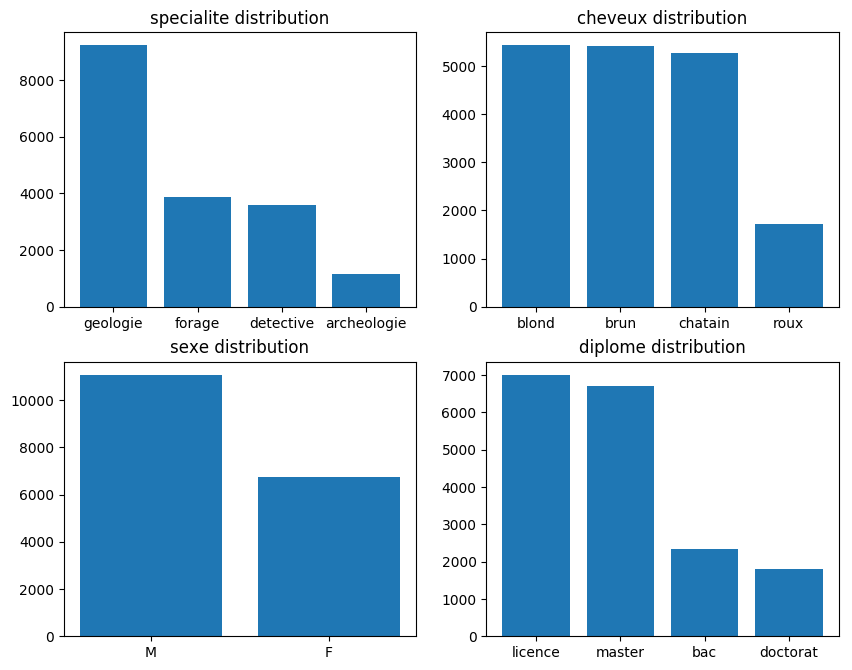

In [11]:
# Distribution et plot des données catégoriques

print(df['specialite'].value_counts()/sum(df['specialite'].value_counts()))
print(df['cheveux'].value_counts()/sum(df['cheveux'].value_counts()))
print(df['sexe'].value_counts()/sum(df['sexe'].value_counts()))
print(df['diplome'].value_counts()/sum(df['diplome'].value_counts()))
print(df['dispo'].value_counts()/sum(df['dispo'].value_counts()))


plt.figure(num=None, figsize=(10, 8), dpi=100)

# specialite
plt.subplot(221)
#plt.subplot(shape=(2,6), loc=(0,0), colspan=2)
plt.bar(df['specialite'].value_counts().index, df['specialite'].value_counts())
plt.title('specialite distribution')
#plt.grid(True)


# cheveux
plt.subplot(222)
#plt.subplot((2,6), (0,2), colspan=2)
plt.bar(df['cheveux'].value_counts().index, df['cheveux'].value_counts())
plt.title('cheveux distribution')
#plt.grid(True)


# sexe
plt.subplot(223)
#plt.subplot((2,6), (0,4), colspan=2)
plt.bar(df['sexe'].value_counts().index, df['sexe'].value_counts())
plt.title('sexe distribution')
#plt.grid(True)

# diplome
plt.subplot(224)
#plt.subplot((2,6), (1,1), colspan=2)
plt.bar(df['diplome'].value_counts().index, df['diplome'].value_counts())
plt.title('diplome distribution')
#plt.grid(True)


#plt.figure.tight_layout()
plt.show()

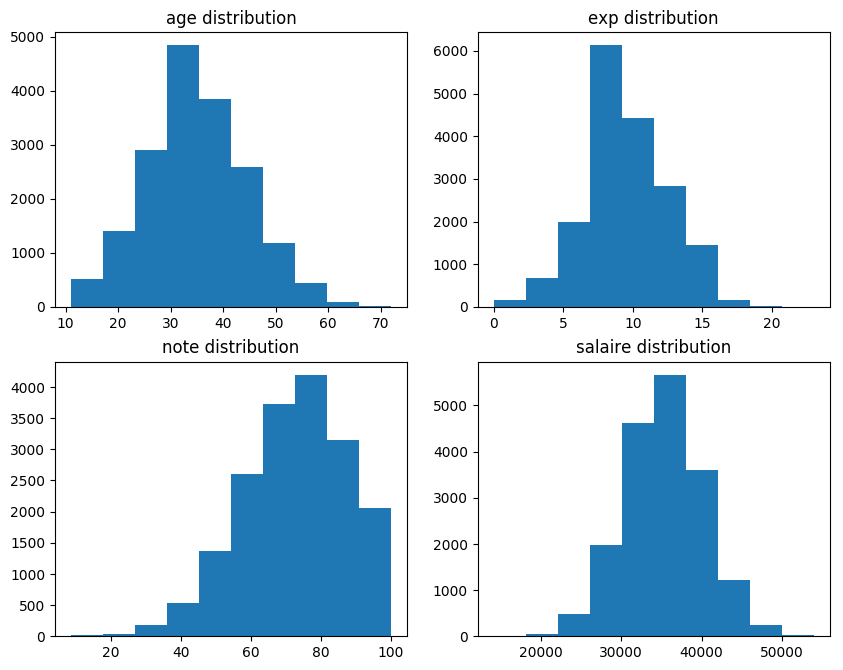

In [12]:
# Plot des distributions des données quantitatives

plt.figure(num=None, figsize=(10, 8), dpi=100)

# specialite
plt.subplot(221)
plt.hist(df['age'])
plt.title('age distribution')
#plt.grid(True)


# cheveux
plt.subplot(222)
plt.hist(df['exp'])
plt.title('exp distribution')


# sexe
plt.subplot(223)
plt.hist(df['note'])
plt.title('note distribution')

# diplome
plt.subplot(224)
plt.hist(df['salaire'])
plt.title('salaire distribution')

plt.show()

## Corrélation

### Données quantitatives

In [13]:
# Regardons s'il existe une corrélation linéaire entre les variables quantitatives
df[['age', 'exp', 'salaire', 'note']].corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,age,exp,salaire,note
age,1.0,0.0064,0.0031,-0.0081
exp,0.0064,1.0,0.0083,-0.016
salaire,0.0031,0.0083,1.0,-0.4
note,-0.0081,-0.016,-0.4,1.0


In [14]:
# Regardons s'il existe une corrélation monotone entre les variables quantitatives
df[['age', 'exp', 'salaire', 'note']].corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,age,exp,salaire,note
age,1.0,0.00011,0.0019,-0.01
exp,0.00011,1.0,0.0051,-0.016
salaire,0.0019,0.0051,1.0,-0.38
note,-0.01,-0.016,-0.38,1.0


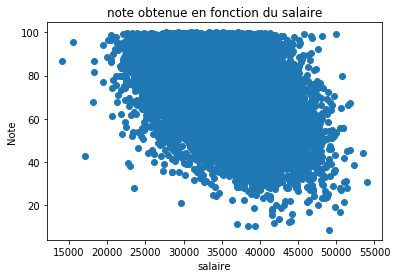

In [15]:
plt.plot(df['salaire'], df['note'], 'o')
plt.xlabel('salaire')
plt.ylabel('Note')
plt.title('note obtenue en fonction du salaire')
plt.show()

## Y a-t-il une dépendance statistiquement significative entre

### c) Le nombre d’années d’expérience et la note à l’exercice ?

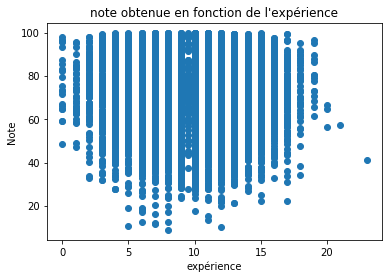

In [16]:
# Plotons une variable en fonction de l'autre pour voir si un type de corrélation
# particulier s'en dégage
plt.plot(df['exp'], df['note'], 'o')
plt.xlabel('expérience')
plt.ylabel('Note')
plt.title('note obtenue en fonction de l\'expérience')
plt.show()

### a)	La spécialité et le sexe ?

In [17]:
# Relation entre le sexe et la spécialité
pivot = pd.pivot_table(df.groupby(['sexe', 'specialite']).count()[['date']].reset_index(), 
               index='sexe', 
               columns='specialite',
               values='date')

pivot

specialite,archeologie,detective,forage,geologie
sexe,,,,
F,884,2109,1674,2101
M,265,1494,2197,7124


In [18]:
chi2, p, dof, expected = chi2_contingency(pivot.values)

In [19]:
print(expected)
# La table de contingence attendue sous l'hypothèse nulle

[[ 435.70327208 1366.26535186 1467.89152846 3498.1398476 ]
 [ 713.29672792 2236.73464814 2403.10847154 5726.8601524 ]]


In [20]:
print(chi2, p)

2338.8826190635277 0.0


### b) La couleur de cheveux et le salaire demandé ?

In [21]:
df.groupby('cheveux')['salaire'].agg({'count':'size', 'mean':'mean', 'std':np.std})

/Users/bzerroug/.virtualenvs/project_/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,count,mean,std
cheveux,,,
blond,5429,34966.917014,4863.050373
brun,5425,35385.447028,4749.799713
chatain,5270,35827.884891,4857.756400
roux,1724,34498.493239,4816.026943


/Users/bzerroug/.virtualenvs/project_/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


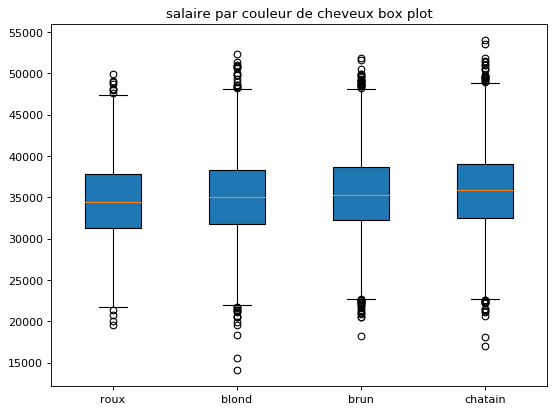

In [22]:
data_box_plot = [df[df['cheveux']==couleur]['salaire'] for couleur in df['cheveux'].unique()]

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.boxplot(data_box_plot,
            vert=True,  
            patch_artist=True,  
            labels=list(df['cheveux'].unique()))  
plt.title('salaire par couleur de cheveux box plot')
plt.show()

In [23]:
stats.kruskal(data_box_plot[0], data_box_plot[1], data_box_plot[2], data_box_plot[3])

KruskalResult(statistic=132.56095770946072, pvalue=1.5175449017282804e-28)

## Les distributions en âge des deux populations (femmes et hommes) sont-elles identiques ?

In [24]:
# On affiche le nombre, la moyenne et l'écart-type de l'âge en fonction du sexe
df.groupby('sexe')['age'].agg({'count':'size', 'mean':'mean', 'std':np.std})

/Users/bzerroug/.virtualenvs/project_/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,count,mean,std
sexe,,,
F,6768,35.188771,9.309775
M,11080,35.169254,9.340229


Text(0.5,1,'age distribution pour sexe = F')

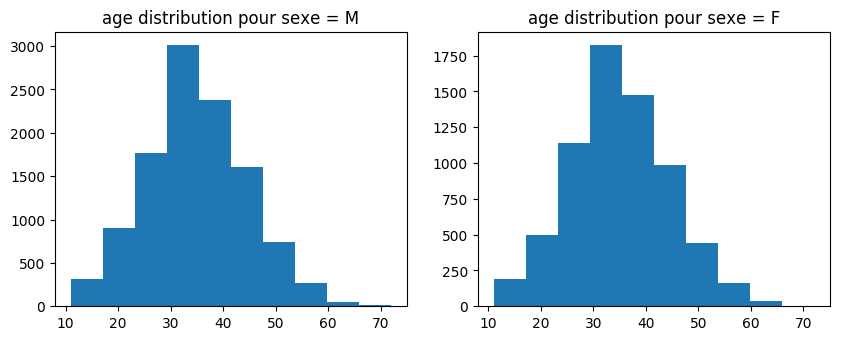

In [25]:
# On plot la distribution de l'âge en fonction du sexe

plt.figure(num=None, figsize=(10, 8), dpi=100)

plt.subplot(221)
plt.hist(df[df['sexe']=='M']['age'])
plt.title('age distribution pour sexe = M')


plt.subplot(222)
plt.hist(df[df['sexe']=='F']['age'])
plt.title('age distribution pour sexe = F')

In [26]:
stats.ks_2samp(df[df['sexe'] == 'M']['age'], df[df['sexe'] == 'F']['age'])

Ks_2sampResult(statistic=0.008990812573076934, pvalue=0.8848884085333107)

# Partie II: Machine Leanring

## Pre-processing

In [27]:
# On ne prend en compte que l'année de candidature
df['year_date'] = df['date'].apply(lambda x: x[:4])

<BarContainer object of 5 artists>

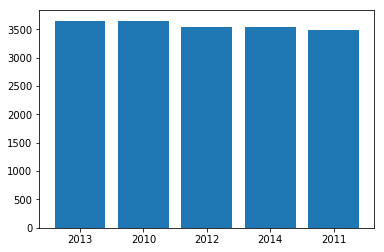

In [28]:
plt.bar(df['year_date'].value_counts().index, df['year_date'].value_counts())
# On voit que la répartition des dates est plutôt uniforme dans l'échantillon

In [29]:
del df['date']

In [30]:
# On transforme les données qualitatives en dummies
df_dummies = pd.get_dummies(df)

In [31]:
df_dummies.head()

,age,exp,salaire,note,embauche,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,sexe_F,...,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui,year_date_2010,year_date_2011,year_date_2012,year_date_2013,year_date_2014
0,25.000000,9.0,26803.0,97.08,0,0,0,0,1,1,...,0,0,1,1,0,0,0,1,0,0
1,35.000000,13.0,38166.0,63.86,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
2,29.000000,13.0,35207.0,78.50,0,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
3,34.987162,12.0,32442.0,45.09,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
4,35.000000,6.0,28533.0,81.91,0,0,0,0,1,1,...,1,0,0,1,0,0,0,1,0,0


In [32]:
# On normalise les données entre 0 et 1
x = df_dummies.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_dummies_normalized = pd.DataFrame(x_scaled)
df_dummies_normalized.columns = df_dummies.columns

In [33]:
df_dummies_normalized.head()

,age,exp,salaire,note,embauche,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,sexe_F,...,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui,year_date_2010,year_date_2011,year_date_2012,year_date_2013,year_date_2014
0,0.229508,0.391304,0.318076,0.968025,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.393443,0.565217,0.603227,0.604249,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.295082,0.565217,0.528972,0.764564,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.393232,0.521739,0.459585,0.398708,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.393443,0.260870,0.361490,0.801905,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Modélisation

### Logistic regression

In [34]:
# On split l'échantillon de départ en X et y puis en train et test
X_df = df_dummies_normalized.drop(columns=['embauche'])
y_df = df_dummies_normalized['embauche']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=42)

In [35]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn/(len(y_test) - sum(y_test)), fp/(len(y_test) - sum(y_test)), fn/sum(y_test), tp/sum(y_test))
print(confusion_matrix(y_test, y_pred))

0.5503084040092521 0.44969159599074787 0.42592592592592593 0.5740740740740741
[[2855 2333]
 [ 299  403]]


In [37]:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
print(precision, recall)

0.1472953216374269 0.5740740740740741


### Random Forest

In [38]:
# On split l'échantillon de départ en X et y puis en train et test
X_df = df_dummies_normalized.drop(columns=['embauche'])
y_df = df_dummies_normalized['embauche']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=42)

In [39]:
# On effectue un premier test de random forest en précisant bien le paramètre class_weight="balanced"
rf = RandomForestClassifier(class_weight="balanced")

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn/(len(y_test) - sum(y_test)), fp/(len(y_test) - sum(y_test)), fn/sum(y_test), tp/sum(y_test))
print(tn, fp, fn, tp)
print(confusion_matrix(y_test, y_pred))

0.9884348496530455 0.01156515034695451 0.688034188034188 0.31196581196581197
5128 60 483 219
[[5128   60]
 [ 483  219]]


In [41]:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
print(precision, recall)

0.7849462365591398 0.31196581196581197


### Optimisation des paramètres

In [42]:
# nombre d'arbres random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# nombre de features pour considérer chaque split
max_features = ['auto', 'sqrt']
# Nombre maximum de niveau dans chaque arbre
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Nombre minimum d'éléments pour spliter un node
min_samples_split = [2, 5, 10]
# Nombre minimum d'éléments pour spliter une feuille
min_samples_leaf = [1, 2, 4]
# Methode de sélection de donnée pour le train de chaque arbre
bootstrap = [True, False]

# Créer le random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': ['balanced'],}

In [43]:
## Random search des paramètres, utilisant 3 fold de cross validation, 
## recherche à travers 100 differentes combinaisons en utilisant tous les cores disponibles
#rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
## Fit du modèle
#rf_random.fit(X_train, y_train)

In [44]:
## Les meilleurs paramètres selon le random search
#best_params = rf_random.best_params_

In [45]:
best_params = {'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [46]:
# Fit avec les meilleurs paramètres et prédiction
rf_gs = RandomForestClassifier(**best_params)
rf_gs.fit(X_train, y_train)

y_pred = rf_gs.predict(X_test)

In [47]:
# Matrice de confusion
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn/(len(y_test) - sum(y_test)), fp/(len(y_test) - sum(y_test)), fn/sum(y_test), tp/sum(y_test))
print(confusion_matrix(y_test, y_pred))

0.980917501927525 0.019082498072474943 0.5441595441595442 0.45584045584045585
[[5089   99]
 [ 382  320]]


In [48]:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
print(precision, recall)

0.7637231503579952 0.45584045584045585


### Upsampling

In [49]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_df, y_df)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

In [51]:
rf_up = RandomForestClassifier(**best_params)

rf_up.fit(X_train, y_train)

y_pred = rf_up.predict(X_test)

In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn/(len(y_test) - sum(y_test)), fp/(len(y_test) - sum(y_test)), fn/sum(y_test), tp/sum(y_test))
print(confusion_matrix(y_test, y_pred))

0.9472678639663737 0.05273213603362629 0.06546929316338354 0.9345307068366164
[[4958  276]
 [ 339 4839]]


In [53]:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
print(precision, recall)

0.9460410557184751 0.9345307068366164


### Optimisation des paramètres sur les données upsamplées

In [54]:
## Random search of parameters, using 3 fold cross validation, 
## search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
## Fit the random search model
#rf_random.fit(X_train, y_train)

In [55]:
#best_params_up = rf_random.best_params_ 

In [56]:
best_params_up = {'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [57]:
rf_up_gs = RandomForestClassifier(**best_params_up)

rf_up_gs.fit(X_train, y_train)

y_pred = rf_up_gs.predict(X_test)

In [58]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn/(len(y_test) - sum(y_test)), fp/(len(y_test) - sum(y_test)), fn/sum(y_test), tp/sum(y_test))
print(confusion_matrix(y_test, y_pred))

0.9533817348108521 0.04661826518914788 0.05117806102742371 0.9488219389725763
[[4990  244]
 [ 265 4913]]


In [59]:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
print(precision, recall)

0.9526856699631568 0.9488219389725763


### Importance des variables

In [60]:
importances = rf_up_gs.feature_importances_

<Figure size 432x288 with 0 Axes>

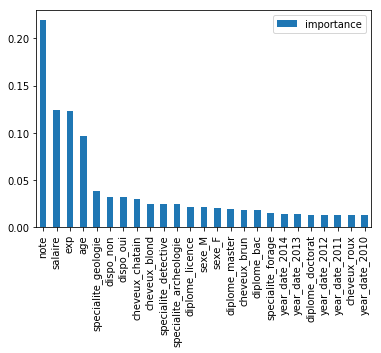

In [61]:
df_importance = pd.DataFrame(importances, index=X_df.columns, columns=['importance']).sort_values(by='importance', ascending=False)

plt.figure()
df_importance.plot.bar()